In [1]:
from matplotlib import pyplot as plt
import cv2
import numpy as np
import dlib
import time
import math
from mpl_toolkits.mplot3d import Axes3D

In [2]:
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor("shape_predictor_68_face_landmarks.dat")
POINTS_NUM_LANDMARK = 68

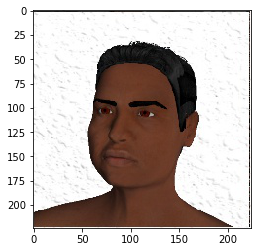

In [3]:
#读取图像
img0 = cv2.imread('man.jpg')
img = img0[:,:,::-1] # 必须为 ::-1
plt.imshow(img) 
plt.show()

In [4]:
# 提取68个特征点
def get_landmarks68(img):
    rects = detector(img, 1)
    if len(rects) == 0:
        return -1
    return np.matrix([[p.x, p.y] for p in predictor(img, rects[0]).parts()])
# 注释68个标记点
def annotate_landmarks68(im):
    img = im.copy()
    landmarks68=get_landmarks68(img)
    for idx, point in enumerate(landmarks68):
        pos = (point[0, 0], point[0, 1])
        #cv2.putText(img, str(idx), pos,fontFace=cv2.FONT_HERSHEY_SCRIPT_SIMPLEX,fontScale=0.4,color=(0, 0, 255))
        cv2.circle(img, pos, 3, color=(0, 255, 255))
    return img

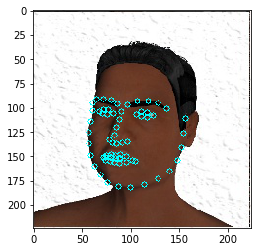

In [5]:
#print(get_landmarks68(img))
a=annotate_landmarks68(img)
plt.imshow(a)
plt.show()

In [6]:
# 手动构建7点人脸3D模型
def model_3D():
    '''
    手动构建7点人脸3D模型，以鼻尖为坐标原点
    :return: 3D模型7点矩阵
    '''
    model_points = np.array([
        (-225.0, 170.0, -135.0),  # 左眼左眼角
        (-75.0, 170.0, -135.0),  # 左眼右眼角，自己定的
        (75.0, 170.0, -135.0),  # 右眼左眼角，自己定的
        (225.0, 170.0, -135.0),  # 右眼右眼角
        (0.0, 0.0, 0.0),  # 鼻尖
        (-150.0, -150.0, -125.0),  # 左嘴角
        (150.0, -150.0, -125.0)  # 右嘴角
    ])
    return model_points

[[-225.  170. -135.]
 [ -75.  170. -135.]
 [  75.  170. -135.]
 [ 225.  170. -135.]
 [   0.    0.    0.]
 [-150. -150. -125.]
 [ 150. -150. -125.]]


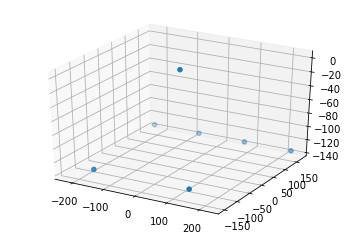

In [7]:
points_3D=model_3D()
print(points_3D)
ax = plt.subplot(111, projection='3d')
ax.scatter(points_3D.T[0],points_3D.T[1],points_3D.T[2])
plt.show()

In [8]:
# 获取最大的人脸
def largest_face(faces):
    '''
    求最大的人脸
    :param faces:detectors检测到的多个人脸的array
    :return:最大人脸的index
    '''
    if len(faces) == 1:
        return 0
    face_areas = [(face.right() - face.left()) * (face.bottom() - face.top()) for face in faces]  # 求脸的大小
    largest_area = face_areas[0]
    largest_index = 0
    for index in range(1, len(faces)):  # 取最大的脸
        if face_areas[index] > largest_area:
            largest_index = index
            largest_area = face_areas[index]
    print("largest_face index is {} in {} faces".format(largest_index, len(faces)))
    return largest_index

In [9]:
# dlib获取人脸7特征点
def get_landmark7(img):
    '''
    用dlib获取人脸7个特征点
    :param img: 输入图片
    :return: 人脸7特征点矩阵(0, landmark7)，若未检测到人脸，返回(-1，None)
    '''
    faces = detector(img, 0)  # 检测图片中的所有人脸,网上都是1，cvdlib中是0
    if len(faces) == 0:  # 没有检测到人脸
        print("ERROR: found no face")
        return None
    largest_index = largest_face(faces)  # 取最大人脸
    face_rectangle = faces[largest_index]  # 取对应人脸框
    landmark68 = predictor(img, face_rectangle)  # dlib检测人脸特征68点
    landmark7 = np.array([  # 取出68点中所需的7个点
        (landmark68.part(36).x, landmark68.part(36).y),  # 左眼左眼角
        (landmark68.part(39).x, landmark68.part(39).y),  # 左眼右眼角
        (landmark68.part(42).x, landmark68.part(42).y),  # 右眼左眼角
        (landmark68.part(45).x, landmark68.part(45).y),  # 右眼右眼角
        (landmark68.part(30).x, landmark68.part(30).y),  # 鼻尖
        (landmark68.part(48).x, landmark68.part(48).y),  # 左嘴角
        (landmark68.part(54).x, landmark68.part(54).y)  # 右嘴角
    ], dtype="double")
    return landmark7

[[  67.  104.]
 [  82.  106.]
 [ 107.  107.]
 [ 124.  107.]
 [  83.  128.]
 [  71.  150.]
 [ 106.  154.]]


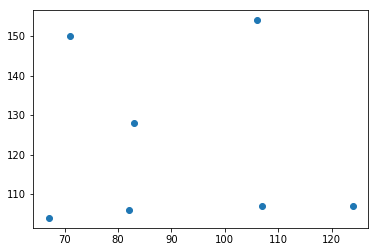

In [10]:
points_2D=get_landmark7(img)
print(points_2D)
plt.scatter(points_2D.T[0],points_2D.T[1])
plt.show()

In [11]:
# 求投影矩阵P
def get_P_matrix(points_3D,points_2D):
    num=points_2D.shape[0]
    _=0 #_是要舍弃的值
    if num<3:
        return -1
    elif num==3:
        _,r1_T=cv2.solve(points_3D.T,points_2D.T[0],_)
        _,r2_T=cv2.solve(points_3D.T,points_2D.T[1],_)
    else:
        _,r1_T=cv2.solve(points_3D,points_2D.T[0],_,cv2.DECOMP_SVD)#奇异值分解
        _,r2_T=cv2.solve(points_3D,points_2D.T[1],_,cv2.DECOMP_SVD)
    r1=r1_T.T[0]
    r2=r2_T.T[0]
    r3=np.cross(r1,r2)
    P=np.array([r1,r2])
    return P

In [12]:
points_3D=model_3D()
P=get_P_matrix(points_3D,points_2D)
P

array([[ 0.12666667, -0.00174699, -0.70590361],
       [ 0.00857143, -0.17518072, -1.00578313]])

In [68]:
#归一化点
def get_normalize(points):
    center=np.sum(points,axis=0)/points.shape[0]
    L=np.sum(np.sum((points-center)**2,axis=1)**0.5)
    normalize=(points-center)/L
    return normalize,center, L

In [71]:
normalize_3D,center_3D, L_3D=get_normalize(points_3D)
normalize_3D,center_3D, L_3D

(array([[-0.15845321,  0.08149022, -0.01559381],
        [-0.05281774,  0.08149022, -0.01559381],
        [ 0.05281774,  0.08149022, -0.01559381],
        [ 0.15845321,  0.08149022, -0.01559381],
        [ 0.        , -0.03822998,  0.07947812],
        [-0.10563547, -0.14386545, -0.00855144],
        [ 0.10563547, -0.14386545, -0.00855144]]),
 array([   0.        ,   54.28571429, -112.85714286]),
 1419.9775883781933)

In [70]:
normalize_2D,center_2D, L_2D=get_normalize(points_2D)
normalize_2D,center_2D, L_2D

(array([[-0.13088119, -0.09796954],
        [-0.05051555, -0.08725412],
        [ 0.08342719, -0.08189642],
        [ 0.17450825, -0.08189642],
        [-0.04515784,  0.03061548],
        [-0.10945035,  0.14848509],
        [ 0.07806948,  0.16991593]]),
 array([  91.42857143,  122.28571429]),
 186.64692750290482)

In [74]:
import scipy
from scipy.optimize import *
def f(x):   # The rosenbrock函数
    return .5*(1 - x[0])**2 + (x[1] - x[0]**2)**2
scipy.optimize.fmin_cg(f, [2, 2],gtol=1e-5)

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 8
         Function evaluations: 80
         Gradient evaluations: 20


array([ 0.99999639,  0.99999253])

In [102]:
#送入优化器的修正的目标函数
def f(K):
    a=0.01
    disparity=(normalize_2D-np.dot(normalize_3D,P.T)).T#disparity:d=b-P*a
    objective=np.sum(disparity**2)#目标函数
    penalty=np.sum((np.ones(K.shape[0])-K)**2*normalize_3D.T[2]**2)#惩罚函数
    revised_objective=objective+a*penalty#修正的目标函数
    return disparity,objective,penalty,revised_objective

In [99]:
disparity,objective,penalty,revised_objective=f(K)
disparity,objective,penalty,revised_objective

(array([[-0.12167581, -0.05469066,  0.06587158,  0.14357215,  0.01087927,
         -0.10235768,  0.05840116],
        [-0.09801985, -0.08820987, -0.08375761, -0.08466306,  0.10385607,
          0.11558719,  0.13520713]]),
 0.13075374002043361,
 1.5459814611806142e-11,
 0.1307537400205882)

In [77]:
f(K_opt)

0.1307537400205882

In [76]:
#K=np.random.random(normalize_3D.shape[0])
K=[1,2,3,0,-3,-1,-1]#随机初始化
K_opt=scipy.optimize.fmin_cg(f, K,gtol=1e-15)
K_opt

Optimization terminated successfully.
         Current function value: 0.130754
         Iterations: 20
         Function evaluations: 1530
         Gradient evaluations: 170


array([ 1.        ,  0.99986839,  0.99985922,  1.00010007,  1.00000155,
        0.99983507,  0.99983507])

In [67]:
normalize_2D,center_2D, L_2D=get_normalize_2D(points_2D)
normalize_2D,center_2D, L_2D

(array([[-0.13088119, -0.09796954],
        [-0.05051555, -0.08725412],
        [ 0.08342719, -0.08189642],
        [ 0.17450825, -0.08189642],
        [-0.04515784,  0.03061548],
        [-0.10945035,  0.14848509],
        [ 0.07806948,  0.16991593]]),
 [91.428571428571416, 122.28571428571429],
 186.64692750290476)

In [67]:
normalize_2D,center_2D, L_2D=get_normalize_2D(points_2D)
normalize_2D,center_2D, L_2D

(array([[-0.13088119, -0.09796954],
        [-0.05051555, -0.08725412],
        [ 0.08342719, -0.08189642],
        [ 0.17450825, -0.08189642],
        [-0.04515784,  0.03061548],
        [-0.10945035,  0.14848509],
        [ 0.07806948,  0.16991593]]),
 [91.428571428571416, 122.28571428571429],
 186.64692750290476)

In [63]:
#get A_K
def get_normalize_3D_K(normalize_3D,K_opt):
    normalize_3D_K=np.array([normalize_3D.T[0],normalize_3D.T[1],normalize_3D.T[2]*K])
    return normalize_3D_K.T

In [64]:
print('normalize_3D=\n',normalize_3D)
normalize_3D_K=get_normalize_3D_K(normalize_3D,K_opt)
print('normalize_3D_K=\n',normalize_3D_K)

normalize_3D=
 [[-0.15845321  0.08149022 -0.01559381]
 [-0.05281774  0.08149022 -0.01559381]
 [ 0.05281774  0.08149022 -0.01559381]
 [ 0.15845321  0.08149022 -0.01559381]
 [ 0.         -0.03822998  0.07947812]
 [-0.10563547 -0.14386545 -0.00855144]
 [ 0.10563547 -0.14386545 -0.00855144]]
normalize_3D_K=
 [[-0.15845321  0.08149022 -0.01559381]
 [-0.05281774  0.08149022 -0.03118761]
 [ 0.05281774  0.08149022 -0.04678142]
 [ 0.15845321  0.08149022 -0.        ]
 [ 0.         -0.03822998 -0.23843435]
 [-0.10563547 -0.14386545  0.00855144]
 [ 0.10563547 -0.14386545  0.00855144]]


[[-0.15845321  0.08149022 -0.01559381]
 [-0.05281774  0.08149022 -0.03118761]
 [ 0.05281774  0.08149022 -0.04678142]
 [ 0.15845321  0.08149022 -0.        ]
 [ 0.         -0.03822998 -0.23843435]
 [-0.10563547 -0.14386545  0.00855144]
 [ 0.10563547 -0.14386545  0.00855144]]


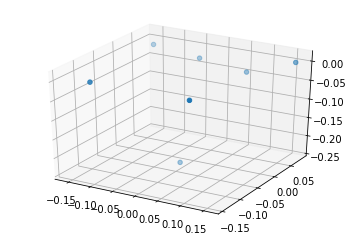

In [67]:
normalize_3D_K=get_normalize_3D_K(normalize_3D,K_opt)
print(normalize_3D_K)
bx = plt.subplot(111, projection='3d')
bx.scatter(normalize_3D_K.T[0],normalize_3D_K.T[1],normalize_3D_K.T[2])
plt.show()

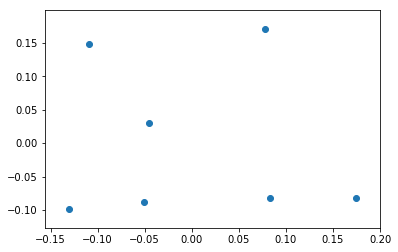

In [68]:
plt.scatter(normalize_2D.T[0],normalize_2D.T[1])
plt.show()

In [69]:
print(normalize_2D.shape)
print(normalize_3D_K.shape)
print(K_opt.shape)
# 得到K修正后的最优投影矩阵
def get_P_opt(normalize_2D, normalize_3D_K):
    '''
    计算K修正后的最优投影矩阵
    :param normalize_2D: 归一化2D特征点
    :param normalize_3D_K: 归一化K修正3D模型
    :return:最优投影矩阵
    '''
    P_opt = np.dot(np.dot(normalize_2D.T, normalize_3D_K), np.linalg.inv(np.dot(normalize_3D_K.T, normalize_3D_K)))
    return P_opt

(7, 2)
(7, 3)
(7,)


In [70]:
P_opt=get_P_opt(normalize_2D,normalize_3D_K,K_opt)
P_opt

array([[ 0.96058351,  0.18178866,  0.14579628],
       [ 0.06439149, -1.08589104,  0.0388106 ]])

In [71]:
print('normalize_3D_K=\n',normalize_3D_K)
print('normalize_3D=\n',normalize_3D)
print('touying=\n',np.dot(P_opt,normalize_3D_K.T).T)
print('normalize_2D=\n',normalize_2D)

normalize_3D_K=
 [[-0.15845321  0.08149022 -0.01559381]
 [-0.05281774  0.08149022 -0.03118761]
 [ 0.05281774  0.08149022 -0.04678142]
 [ 0.15845321  0.08149022 -0.        ]
 [ 0.         -0.03822998 -0.23843435]
 [-0.10563547 -0.14386545  0.00855144]
 [ 0.10563547 -0.14386545  0.00855144]]
normalize_3D=
 [[-0.15845321  0.08149022 -0.01559381]
 [-0.05281774  0.08149022 -0.01559381]
 [ 0.05281774  0.08149022 -0.01559381]
 [ 0.15845321  0.08149022 -0.01559381]
 [ 0.         -0.03822998  0.07947812]
 [-0.10563547 -0.14386545 -0.00855144]
 [ 0.10563547 -0.14386545 -0.00855144]]
touying=
 [[-0.13966706 -0.09929774]
 [-0.04046889 -0.09310092]
 [ 0.05872929 -0.0869041 ]
 [ 0.16702153 -0.07828646]
 [-0.04171262  0.03225981]
 [-0.12637803  0.14975206]
 [ 0.07656535  0.16335612]]
normalize_2D=
 [[-0.13088119 -0.09796954]
 [-0.05051555 -0.08725412]
 [ 0.08342719 -0.08189642]
 [ 0.17450825 -0.08189642]
 [-0.04515784  0.03061548]
 [-0.10945035  0.14848509]
 [ 0.07806948  0.16991593]]


In [72]:
# 由最优投影矩阵计算欧拉角
def get_euler_angle(P_opt):
    '''
    由最优投影矩阵计算欧拉角
    :param P_opt: 最优投影矩阵
    :return: 欧拉角
    '''
    theta=np.array([0,0,0])#(theta x,y,z)
    r1=P_opt[0]
    r2=P_opt[1]
    r3=np.cross(r1,r2)
    print('r3=',r3)
    theta[0]=math.atan(r3[1]/r3[2])/math.pi*180
    theta[1]=-math.atan(r3[0]/(r3[1]**2+r3[2]**2)**0.5)/math.pi*180
    theta[2]=math.atan(r2[0]/r1[0])/math.pi*180
    return theta

In [73]:
theta=get_euler_angle(P_opt)
theta

r3= [ 0.16537421 -0.02789278 -1.05479467]


array([ 1, -8,  3])

In [74]:
print(center_3D)
print(L_3D)
print(center_2D)
print(L_2D)

[0.0, 54.285714285714278, -112.85714285714286]
1419.97758838
[91.428571428571416, 122.28571428571429]
186.646927503


In [99]:
print(far_3D)
print(far_3D-center_3D)
print((far_3D-center_3D)/L_3D)
#print(np.dot((far_3D-center_3D)/L_3D).T,P_opt.T)
print(np.dot(np.dot(P_opt,(far_3D-center_3D)/L_3D),L_2D))
print(np.dot(np.dot(((far_3D-center_3D)/L_3D).T,P_opt.T),L_2D)+center_2D)

[    0.     0.  1000.]
[    0.           -54.28571429  1112.85714286]
[ 0.         -0.03822998  0.78371458]
[ 20.02962247  13.42551846]
[ 111.4581939   135.71123275]


p1= (83, 128) p2= (111, 135)


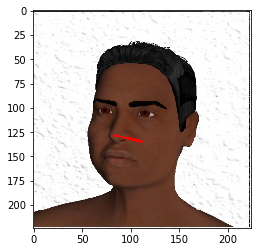

In [107]:
nose_tip_2D=(int(points_2D[4][0]), int(points_2D[4][1]))
far_3D=np.array([0.0, 0.0, 1000.0])
far_2D=np.dot(np.dot(P_opt,(far_3D-center_3D)/L_3D),L_2D)+center_2D
p1=(int(nose_tip_2D[0]),int(nose_tip_2D[1]))
p2=(int(far_2D[0]),int(far_2D[1]))
print('p1=',p1,'p2=',p2)
img_with_line = np.copy(img)
cv2.line(img_with_line, p1,p2, (255, 0, 0), 2)
plt.imshow(img_with_line)
plt.show()

In [78]:
# 画表示姿势的线
def draw_line(img,points_2D):
    nose_tip_2D=(int(points_2D[4][0]), int(points_2D[4][1]))  # 鼻尖
    normalize_nose_tip_2D=(points_2D[4]-center_2D)
    far_away_3D=np.array([0.0, 0.0, 1000.0])
    #normalize
    far_away_2D=np.dot(P_opt,far_away_3D.T).T
    p1=(int(nose_tip_2D[0]),int(nose_tip_2D[1]))
    p2=(int(far_away_2D[0]),int(far_away_2D[1]))
    print(p1,p2)
    img_with_line = np.copy(img)
    cv2.line(img_with_line, p1,p2, (255, 0, 0), 2)
    return img_with_line

(83, 128) (145, 38)


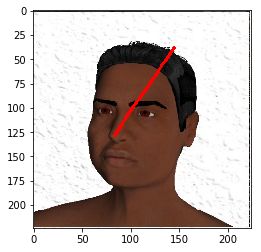

In [79]:
img_with_line=draw_line(img,points_2D)
plt.imshow(img_with_line)
plt.show()